### Interactive Highways

This project demonstrates how to overlay highway features on Open Street Map (OSM) on the example of Highways 407, 412 and 418. In addition, it shows how to add basic highway metrics, like Annual Average Daily Traffic (AADT), and make highway features interactactive by clicking on them.
#### Data

* Highway network was obtained from OSM by exporting all the features in the area of interest in small blocks. These blocks were then merged in QGIS. Then, using a table of attributes, toll roads were selected and then exported.

* Highway interchnages were obtained using Google Maps by finding latitude, longitude of each interchnage

* AADT values are fictional and 

* CRS: ESPG4326 (WGS84, lat, lon)

Date: March 16, 2021

In [1]:
# import modules
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium
import mplleaflet
import os

Position our field view above Highways 407, 412 and 418. Use folium module for this task. Note that coordinates are provided in the format [lat, lon]

In [2]:
m = folium.Map(location=[43.9511982,-79.0168722], zoom_start=10, control_scale=True)

In [3]:
m

Define a file path and files to be used in the project. Specifically, we use two files in *.shp file format. Files are located in the folder '/docs'. Note that shapefile is a common file format for GIS files, and they can be loaded by geopandas in a simple way.

In [4]:
# define a file path
fp = r'docs'

# define files paths
roads_fname = os.path.join(fp, 'Toll_hwy.shp')
hwy_attr_fname = os.path.join(fp, 'Highway_attributes.csv')
inter_fname = os.path.join(fp, 'Interchanges.shp')

print(roads_fname,'\n', hwy_attr_fname,'\n', inter_fname)

docs\Toll_hwy.shp 
 docs\Highway_attributes.csv 
 docs\Interchanges.shp


Roads file contains three fields, id, segid and geometry. SEGID stands for segment id.

In [5]:
# read road file as geo df and explore its content
roads = gpd.read_file(roads_fname)

roads.head(3)

,id,SEGID,geometry
0,1,407001,"LINESTRING (-79.09797 43.91841, -79.09796 43.9..."
1,2,407002,"LINESTRING (-79.02113 43.94966, -79.01587 43.9..."
2,3,407003,"LINESTRING (-79.00924 43.95096, -78.99023 43.9..."


Explore coordinate system for properties, also referred to as crs. Here we find that crs is espg: 4326. This crs is based on ellipsoid WGS84 and it's coordinate system uses geographic units (lat, lon). This crs is suitable for folium module and thus we keep its properties without further changes.

In [6]:
roads.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Create a plot of roads shape file. From this plot we observe that toll highway consists of three highways: 
* Highway 407, which traverses from east to west, and is the longest section (~44 km)
* Highway 412, which traverses from north to south and is a western highway (~10 km)
* Highway 418, which traverses from north to south and is an easter highway (~10 km)

The total length is approximately 64 km.

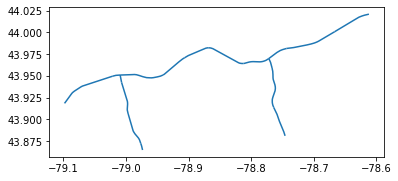

In [7]:
# plot roads
roads.plot();

Let's load attributes file and review it. Attributes file has five fields, namely SEGID, Highway, Name, AADT18 and AADT19. Considering that 'csv' file is a comma-delimited file, other segment-related attributes can be added, like traffic volume trips, speed, volume-to-capacity ratio, among others. The description of included fields is provided below. 

* SEGID - has keys required to join csv with roads. 
* Highway - identifies highways: 407, 412 or 418. 
* Name - descibes the segment name between two sequential interchnages.
* AADT18/19 - fictional annual average daily traffic 

In [8]:
# load highway attributes file
attr = pd.read_csv(hwy_attr_fname, sep=',')

attr.head(3)

,SEGID,Highway,Name,AADT18,AADT19
0,407001,407,Brock-LakeRidge,1000,1050
1,407002,407,LakeRidge-Hwy412,1500,1575
2,407003,407,Hwy412-Baldwin,2000,2100


In [9]:
# check data of SEGID keys before merging two datasets
# data types do not match
type(roads['SEGID'][0]), type(attr['SEGID'][0])

(str, numpy.int64)

In [10]:
# convert data type of SEGID from attributes file to a string type
attr['SEGID']=attr['SEGID'].apply(lambda x:str(x))

# check data type again
print(type(roads['SEGID'][0]), type(attr['SEGID'][0]))

type(roads['SEGID'][0]) == type(attr['SEGID'][0])

<class 'str'> <class 'str'>


True

In [11]:
# Merge data sets, where roads is the main file because it has crs
iHwy = roads.merge(attr, on='SEGID')

iHwy.head(3)

,id,SEGID,geometry,Highway,Name,AADT18,AADT19
0,1,407001,"LINESTRING (-79.09797 43.91841, -79.09796 43.9...",407,Brock-LakeRidge,1000,1050
1,2,407002,"LINESTRING (-79.02113 43.94966, -79.01587 43.9...",407,LakeRidge-Hwy412,1500,1575
2,3,407003,"LINESTRING (-79.00924 43.95096, -78.99023 43.9...",407,Hwy412-Baldwin,2000,2100


Load interchanges file and review its content

In [12]:
interchanges = gpd.read_file(inter_fname)

interchanges.head(3)

,Highway,Interchang,Latitude,Longitude,geometry
0,407,Brock407,43.918415,-79.097968,POINT (-79.09797 43.91841)
1,407,LakeRidge,43.949670,-79.021130,POINT (-79.02113 43.94967)
2,407,Hwy412,43.950967,-79.009221,POINT (-79.00922 43.95097)


In [13]:
# confirm that both datasets have a common crs
interchanges.crs == roads.crs

True

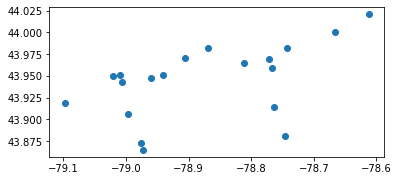

In [14]:
# plot interchnages
interchanges.plot();

Interchange file has 19 unique interchnages

In [15]:
interchanges.nunique()

Highway        3
Interchang    19
Latitude      19
Longitude     19
geometry      19
dtype: int64

In [16]:
interchanges.columns

Index(['Highway', 'Interchang', 'Latitude', 'Longitude', 'geometry'], dtype='object')

In [17]:
# add road network
folium.GeoJson(data=iHwy,
               name="Highway 407 East",
               style_function=lambda x:{"weight":2, 'color':'blue','fillOpacity':0.2},
               highlight_function=lambda x: {'weight':3, 'color':'black'},
               smooth_factor=2.0,
               tooltip=folium.features.GeoJsonTooltip(fields=['Name','AADT18'],
                                                      aliases=['Segment Name', 'AADT18'],
                                                      labels=True,
                                                      sticky=True
                                                     )
              ).add_to(m)



# add interchanges
folium.GeoJson(data=interchanges,
               name="Interchanges",
               style_function=lambda x:{"weight":10, 'color':'red','fillOpacity':0.2},
               highlight_function=lambda x: {'weight':3, 'color':'black'},
               smooth_factor=2.0,
               tooltip=folium.features.GeoJsonTooltip(fields=['Interchang'],
                                                      aliases=['Interchange'],
                                                      labels=True,
                                                      sticky=True
                                                     )
              ).add_to(m)


folium.LayerControl().add_to(m)

m

Save the interactive map as a html file

In [18]:
outfp = r'docs/interactive_highway.html'
m.save(outfp)